In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve

In [2]:
# Load the data
traindf = pd.read_csv("a3_train_final.tsv", sep='\t', header=None, names=['stance', 'comment'])
testdf = pd.read_csv("a3_test.tsv", sep='\t', header=None, names=['stance', 'comment'])

## Data exploration/Check consensus among annotators

Percentage of comments with complete consensus among annotators: 84.717%. Number of comments in consensus: 32095


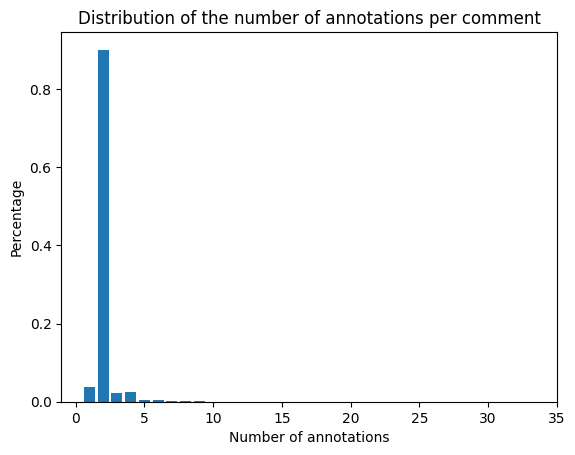

In [3]:
# Calculate different metrics to measure consensus among annotators
def consensus_info_func(df):
    tot_count = 0
    consensus_count = 0
    nr_of_annotations = []
    for line in df['stance']:
        annotations = line.split('/')
        
        nr_of_annotations.append(len(annotations))

        tot_count += 1
        if len(set(annotations)) == 1 and not (-1 in annotations):
            consensus_count += 1
    
    return consensus_count/tot_count, consensus_count, nr_of_annotations

consensus_fraction, consensus_count, nr_of_annotations = consensus_info_func(traindf)


annotation_counter = Counter(nr_of_annotations)
annotation_fractions = [annotation_counter[i]/sum(annotation_counter.values()) for i in annotation_counter]
plt.bar(annotation_counter.keys(), annotation_fractions)
plt.title("Distribution of the number of annotations per comment")
plt.ylabel("Percentage")
plt.xlabel("Number of annotations")
plt.savefig("dist_number_of_annotations_per_comment.png")


print("Percentage of comments with complete consensus among annotators: {:.3f}%. Number of comments in consensus: {}".format(consensus_fraction*100, consensus_count))



## Feature processing

In [4]:
# Get rows with -1 or or rows that are longer than 2 or not in consensus
def df_get_rows_not_in_consensus_or_longer_than_2_annotations(data):
    rows_with_minus_one = []
    rows_not_in_consensus = []
    rows_longer_than_2 = []
    row = 0
    for line in data['stance']:
        annotations = line.split('/')

        if (len(annotations) > 2):
            rows_longer_than_2.append(row)
            row += 1
            continue

        if ('-1' in annotations):
            rows_with_minus_one.append(row)
            row += 1
            continue

        if len(set(annotations)) > 1:
            rows_not_in_consensus.append(row)
            row += 1
            continue
        
        row += 1
    return rows_with_minus_one, rows_not_in_consensus, rows_longer_than_2


In [5]:
#Remove row from training data that have more than 2 annotations and not in consensus
def remove_rows_not_in_consensus_or_more_than_2_annotations(data):
    rows_with_minus_one, rows_not_in_consensus, rows_longer_than_2 = df_get_rows_not_in_consensus_or_longer_than_2_annotations(data)

    to_be_removed = rows_with_minus_one + rows_longer_than_2 + rows_not_in_consensus

    data_only_consensus = data.drop(to_be_removed)
    data_only_consensus = data_only_consensus.replace({"stance": {"1/1":"1", "0/0":"0"}})
    data_only_consensus = data_only_consensus.astype({"stance":"int"})

    return data_only_consensus

traindf_only_consensus = remove_rows_not_in_consensus_or_more_than_2_annotations(traindf)

In [6]:
# How many comments left?
print("Amount of reliable comments: {}".format(len(traindf_only_consensus)))
print("Which is {:.0f}% of the total amount of comments in the training data".format(100*len(traindf_only_consensus)/len(traindf)))

Amount of reliable comments: 30136
Which is 80% of the total amount of comments in the training data


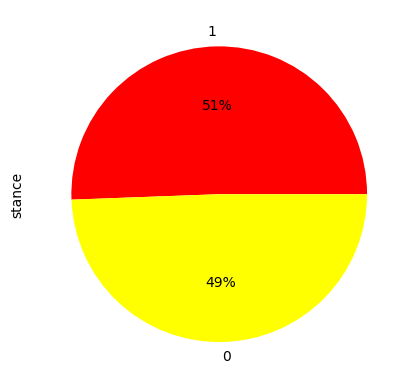

In [7]:
# Check if data set labels are balanced
traindf_only_consensus['stance'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow"])
plt.savefig("labelbalance.png")

### Exploring stopwords

In [9]:
# Creating different tfid vectorizers to test the effect of min_df and max_df
tfidf_vect_l2 = TfidfVectorizer(strip_accents='ascii',min_df = 0.0001, max_df=0.7, norm='l2')
tfidf_vect = TfidfVectorizer(strip_accents='ascii',min_df = 0.0001, max_df=0.7, norm=None)

# Vectorizing data
vectorized_l2 = tfidf_vect_l2.fit_transform(traindf_only_consensus['comment'])
vectorized_no_norm = tfidf_vect.fit_transform(traindf_only_consensus['comment'])
vectorized_test = tfidf_vect.transform(testdf['comment'])
#vectorized_l2

In [10]:
# exploring the effects and the stop words 
print(len(tfidf_vect_l2.stop_words_))
print(tfidf_vect_l2.stop_words_)

print(len(tfidf_vect.stop_words_))
print(tfidf_vect.stop_words_)

13618
{'trypophobia', 'deniability', 'reaffirms', 'delusion', 'flames', 'tummy', 'tromp', 'installation', 'jonas', 'evidenceless', '832', 'astrazenecakills', 'panties', 'flues', 'affraid', 'puking', 'trees', 'esoteric', 'truthuk', 'instill', '7575', 'commuinty', 'mathematically', 'nephews', 'unstoppable', 'shudder', 'barbaric', 'unvaccinted', 'fitnessmamma', 'marksteynonline', 'radicalized', 'mortified', 'sensitizing', 'wet', 'gaslit', 'communal', 'dreading', 'camus', 'vocabulary', 'advancing', '575', 'gynecologists', 'aunts', 'masquerading', 'draws', 'bakunation', 'beers', 'doggone', 'vaxxtard', 'reviving', 'synthetics', 'ci', 'nowdays', 'fken', 'richmond', 'ios', 'suddendeath', 'huuuummmm', 'adopt', 'sited', 'sty', 'uterus', '2011', 'momma', 'budweiser', 'shire', 'shielded', 'chihuahua', 'satanism', 'sword', 'crapy', 'chestnut', 'deciede', 'enought', 'handprint', 'bigfoot', 'laboratories', 'penetrate', 'backward', 'omelet', 'cheated', 'tenth', 'colbert', 'mcclung', 'heresy', 'ahah', 

3e-05
nr of words ignored in l2 in all0
6e-05
nr of words ignored in l2 in all9615
9e-05
nr of words ignored in l2 in all12224
0.00012
nr of words ignored in l2 in all13618
0.00025
nr of words ignored in l2 in all15976
0.00035
nr of words ignored in l2 in all16699
0.00045
nr of words ignored in l2 in all17174
0.00085
nr of words ignored in l2 in all18169


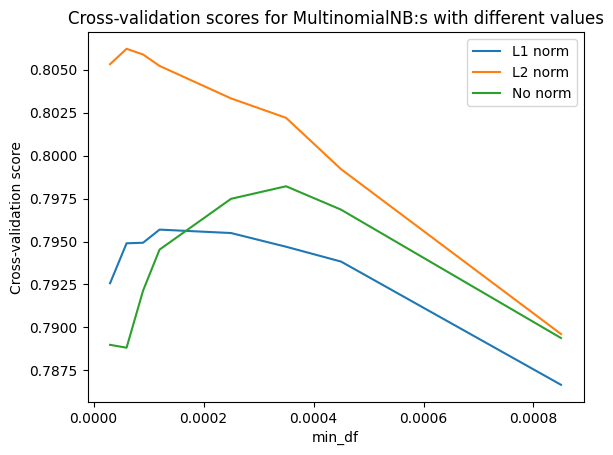

In [ ]:
# Vizualizing the effects of the different vectorizers with
# Multinomial Naive Bayes cross validation
def cross_MNB(hyperparameter_list):
    result_list_l1_norm = []
    result_list_l2_norm = []
    result_list_no_norm = []
    
    for h in hyperparameter_list:
        tfidf_vect_l1 = TfidfVectorizer(strip_accents='ascii',min_df = h, norm='l1')
        tfidf_vect_l2 = TfidfVectorizer(strip_accents='ascii',min_df = h, norm='l2')
        tfidf_vect = TfidfVectorizer(strip_accents='ascii',min_df = h, norm=None)

        vectorized_l1 = tfidf_vect_l1.fit_transform(traindf_only_consensus['comment'])
        vectorized_l2 = tfidf_vect_l2.fit_transform(traindf_only_consensus['comment'])
        vectorized_no_norm = tfidf_vect.fit_transform(traindf_only_consensus['comment'])
        mnb = MultinomialNB(alpha = 1)
        scores_l1 = cross_val_score(mnb, vectorized_l1, traindf_only_consensus['stance'], n_jobs = -1)
        result_list_l1_norm.append(np.mean(scores_l1))

        scores_l2 = cross_val_score(mnb, vectorized_l2, traindf_only_consensus['stance'], n_jobs = -1)
        result_list_l2_norm.append(np.mean(scores_l2))

        scores_no_norm = cross_val_score(mnb, vectorized_no_norm, traindf_only_consensus['stance'], n_jobs = -1)
        result_list_no_norm.append(np.mean(scores_no_norm))
        print(h)
        print("nr of words ignored in l2 in all vectorizers: " + str(len(tfidf_vect_l1.stop_words_)))

    plt.plot(hyperparameter_list, result_list_l1_norm, label = "L1 norm")
    plt.plot(hyperparameter_list, result_list_l2_norm, label = "L2 norm")
    plt.plot(hyperparameter_list, result_list_no_norm, label = "No norm")
    plt.legend()
    plt.title("Cross-validation scores for MultinomialNB:s with different values")
    plt.ylabel("Cross-validation score")
    plt.xlabel("min_df")
    plt.show()

#cross_MNB([3e-05,3.05e-05, 3.1e-05, 3.3e-05, 3.4e-05])
cross_MNB([3e-05,6e-05, 9e-05, 12e-05, 25e-05,35e-05,45e-05, 85e-05])

### Vectorization of comments data

In [ ]:
# TFID Vectorize the train and test data
tfid_vect = TfidfVectorizer(strip_accents='ascii', norm='l2')

vectorized_train_consensus = tfid_vect.fit_transform(traindf_only_consensus['comment'])
vectorized_test = tfid_vect.transform(testdf['comment']) # Use same vectorizer for test data

## Learning algorithm selection/hyperparameter tuning

### Random forest

175
200
225
250
275


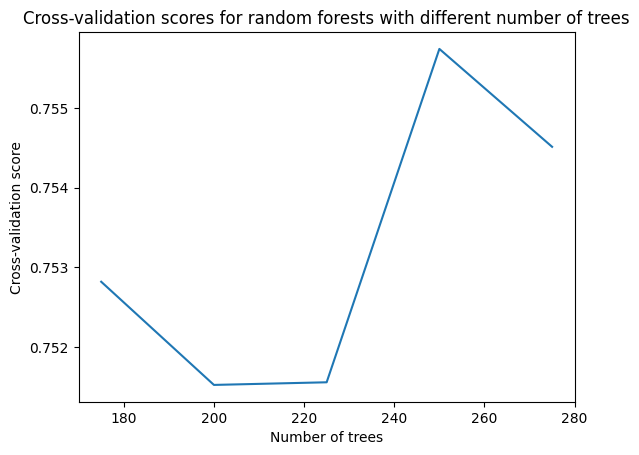

In [ ]:
# Random forest cross validation to find best n_estimators
def cross_RF_estimators(hyperparameter_list):
    result_list = []

    for h in hyperparameter_list:
        rf = RandomForestClassifier(criterion='gini', n_estimators = h, max_depth = 15)
        scores = cross_val_score(rf, vectorized_train_consensus, traindf_only_consensus['stance'], n_jobs = -1)
        result_list.append(np.mean(scores))
        print(h)

    plt.plot(hyperparameter_list, result_list)
    plt.title("Cross-validation scores for random forests with different number of trees")
    plt.ylabel("Cross-validation score")
    plt.xlabel("Number of trees")
    plt.savefig("cross_val_randomforest.png")
    plt.show()


cross_RF_estimators([175, 200, 225, 250, 275])

40
60
80
100
120


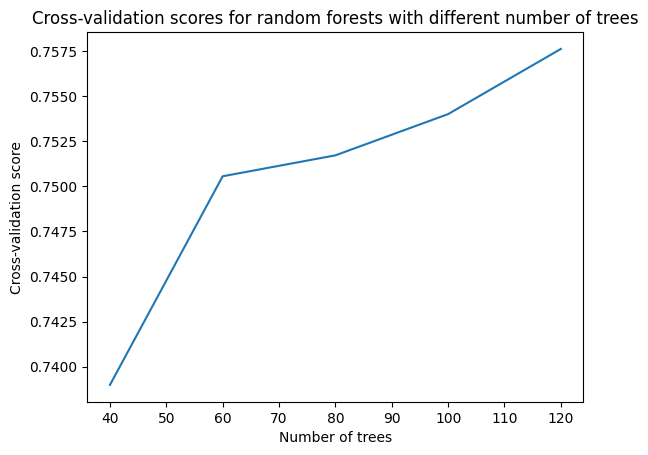

In [ ]:
# Random forest cross validation to find best n_estimators
def cross_RF_estimators(hyperparameter_list):
    result_list = []

    for h in hyperparameter_list:
        rf = RandomForestClassifier(criterion='gini', n_estimators = h, max_depth= 20, n_jobs = -1)
        scores = cross_val_score(rf, vectorized_train_consensus, traindf_only_consensus['stance'])
        result_list.append(np.mean(scores))
        print(h)

    plt.plot(hyperparameter_list, result_list)
    plt.title("Cross-validation scores for random forests with different number of trees")
    plt.ylabel("Cross-validation score")
    plt.xlabel("Number of trees")
    #plt.savefig("cross_val_randomforest.png")
    plt.show()


cross_RF_estimators([40, 60, 80, 100, 120])

50
75
100


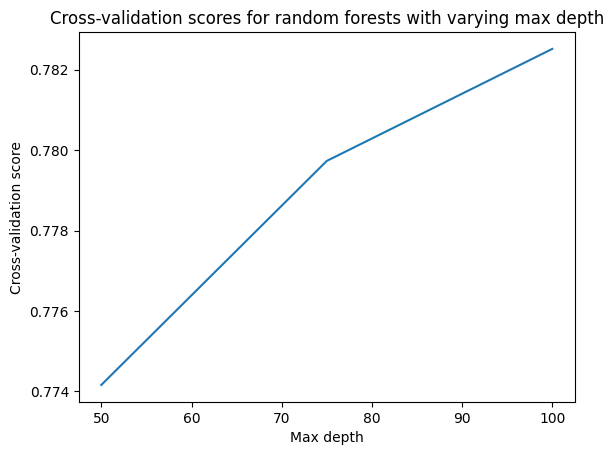

In [ ]:
def cross_RF_depth(hyperparameter_list):
    result_list = []

    for h in hyperparameter_list:
        rf = RandomForestClassifier(criterion='gini', n_estimators = 120, max_depth= h, n_jobs = -1)
        scores = cross_val_score(rf, vectorized_train_consensus, traindf_only_consensus['stance'])
        result_list.append(np.mean(scores))
        print(h)

    plt.plot(hyperparameter_list, result_list)
    plt.title("Cross-validation scores for random forests with varying max depth")
    plt.ylabel("Cross-validation score")
    plt.xlabel("Max depth")
    plt.savefig("cross_val_randomforest_max_depth.png")
    plt.show()


cross_RF_depth([50, 75, 100])

### Naive Bayes

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


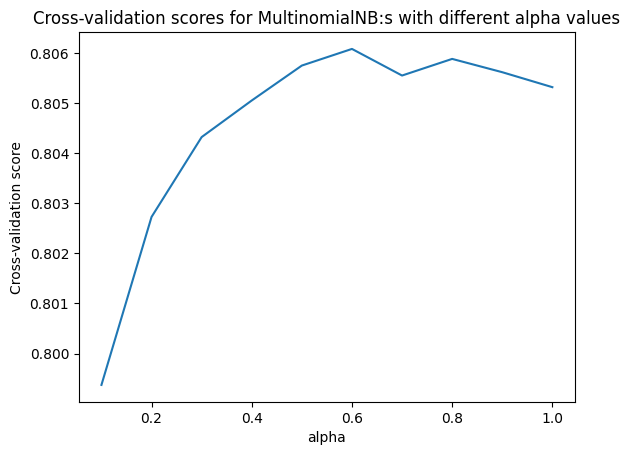

In [ ]:
# Multinomial Naive Bayes cross validation
def cross_MNB(hyperparameter_list):
    result_list = []
    
    for h in hyperparameter_list:
        mnb = MultinomialNB(alpha = h)
        scores = cross_val_score(mnb, vectorized_train_consensus, traindf_only_consensus['stance'], n_jobs = -1)
        result_list.append(np.mean(scores))

        print(h)

    plt.plot(hyperparameter_list, result_list)
    plt.title("Cross-validation scores for MultinomialNB:s with different alpha values")
    plt.ylabel("Cross-validation score")
    plt.xlabel("alpha")
    plt.savefig("cross_val_multinomialNB.png")
    plt.show()

cross_MNB([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


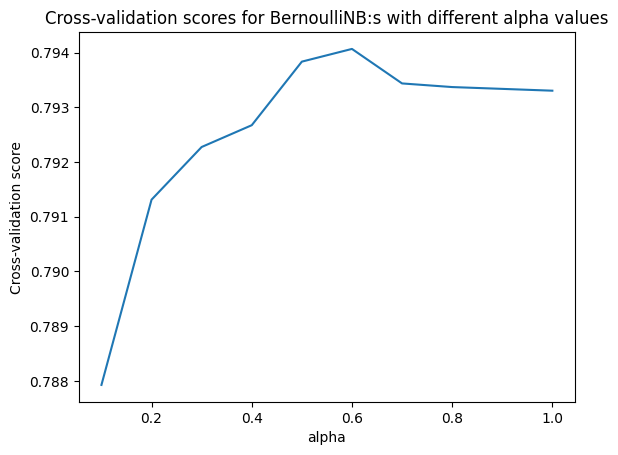

In [ ]:
# Bernoulli Naive Bayes cross validation
def cross_BNB(hyperparameter_list):
    result_list = []

    
    for h in hyperparameter_list:
        bnb = BernoulliNB(alpha = h)
        scores = cross_val_score(bnb, vectorized_train_consensus, traindf_only_consensus['stance'], n_jobs = -1)
        result_list.append(np.mean(scores))

        print(h)

    plt.plot(hyperparameter_list, result_list)
    plt.title("Cross-validation scores for BernoulliNB:s with different alpha values")
    plt.ylabel("Cross-validation score")
    plt.xlabel("alpha")
    plt.savefig("cross_val_bernoulliNB.png")
    plt.show()

cross_BNB([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### KNeighbors classifier

10
20
30
40
50


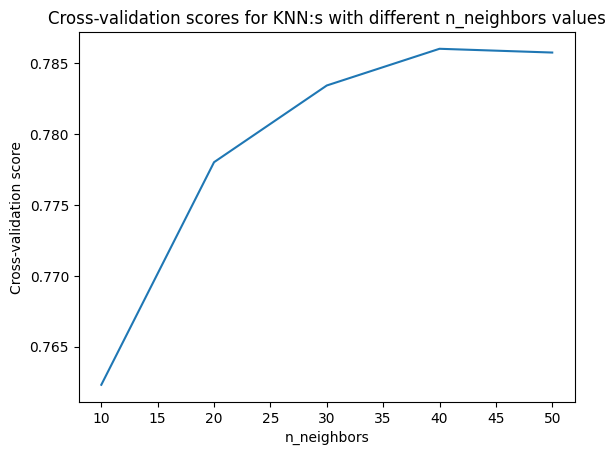

In [ ]:
# KNN cross validation
def cross_KNN(hyperparameter_list):
    result_list = []

    for h in hyperparameter_list:
        knn = KNeighborsClassifier(n_neighbors = h)
        scores = cross_val_score(knn, vectorized_train_consensus, traindf_only_consensus['stance'], n_jobs = -1)
        result_list.append(np.mean(scores))
        print(h)

    plt.plot(hyperparameter_list, result_list)
    plt.title("Cross-validation scores for KNN:s with different n_neighbors values")
    plt.ylabel("Cross-validation score")
    plt.xlabel("n_neighbors")
    plt.savefig("cross_val_KNN.png")
    plt.show()

cross_KNN([10, 20, 30, 40, 50])

### Trivial baseline

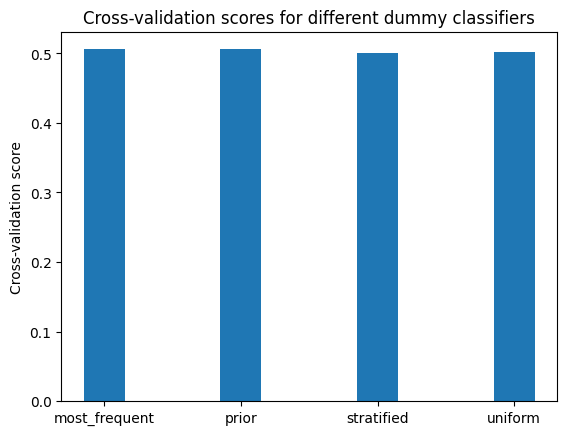

In [ ]:
# Trivial baseline cross validation
def cross_trivial_baseline(hyperparameter_list):
    result_list = []

    for h in hyperparameter_list:
        dc = DummyClassifier(strategy = h)
        scores = cross_val_score(dc, vectorized_train_consensus_l1, traindf_only_consensus['stance'])
        result_list.append(np.mean(scores))

    plt.bar(hyperparameter_list, result_list, width = 0.3)
    plt.title("Cross-validation scores for different dummy classifiers")
    plt.ylabel("Cross-validation score")
    plt.show("Strategy")

cross_trivial_baseline(["most_frequent", "prior", "stratified", "uniform"])

## Evaluation

5 misslassified comments:
True label: 1  |  I did my own research means you looked online at what you already believed in, and then the algorithm kept feeding you your own opinion, making you believe you are right. Instead of believing the actual scientific research or doctors who actually studied this. Also the "I knew someone who had a bad reaction" is not a reason. Not if you simply ignore the millions of people who had no bad reaction.
True label: 1  |  I don't know what's in it. As if they know what's in the hamburgers they eat, the milk they drink, the high fructose corn syrup they consume... what a tragedy of stupidity.
True label: 0  |  95% effective for a virus that kills at 0.5%.
True label: 1  |  A big thanks to Germany! Biontech FTW! :-)
True label: 1  |  A good friend is recovering after covid, having refused vaccination. He is confused and has trouble focusing. He remembers that he wasn't that way before. A solid hit with covid leaves patients with an average of a seven I

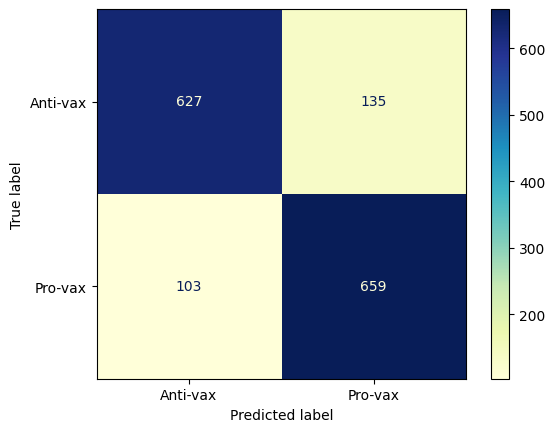

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


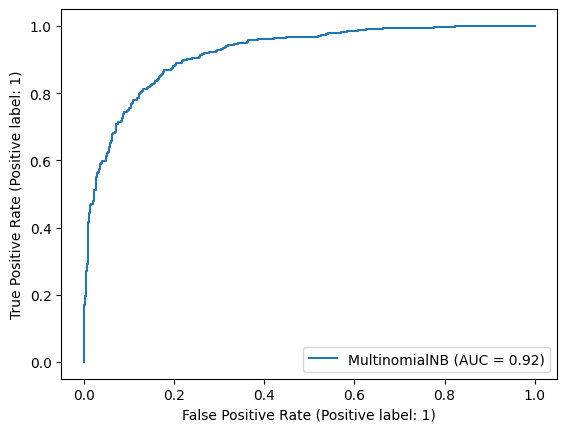

Most important anti-vaccination words: ['the' 'vaccine' 'to' 'it' 'not' 'and' 'is' 'you' 'of' 'that' 'no' 'are'
 'this' 'my' 'for' 'they' 'in' 'covid' 'take' 'vaccines']
Most important pro-vaccination words: ['the' 'to' 'and' 'vaccine' 'of' 'get' 'it' 'my' 'is' 'you' 'for'
 'vaccinated' 'covid' 'in' 'are' 'vaccines' 'that' 'have' 'got' 'this']


In [ ]:
# Run best machine learning model on test data
def test_algo(classifier, X_test_vectorized, X_test_not_vectorized, y_test):
    # Train and predict
    classifier.fit(vectorized_train_consensus, traindf_only_consensus['stance'])
    y_pred = classifier.predict(X_test_vectorized)

    # Print 5 cases that were missclassified
    print("5 misslassified comments:")
    i=0
    X_np = X_test_not_vectorized.to_numpy()
    y_np = y_test.to_numpy()
    for (p,t,comment) in zip(y_pred, y_np, X_np):
        if i == 5:
            break
        elif (np.random.rand() < 0.5): # To not get same comments every time the function is executed
            continue
        elif p != t:
            print("True label: {}  |  {}".format(t,comment))
            i += 1
    print("-------------------------------------------------")

    # Print a classification report
    print(classification_report(y_test, y_pred, target_names = ["Anti-vax", "Pro-vax"]))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Accuracy
    acc = (tn+tp)/(tn+tp+fp+fn)
    print("Total accuracy of model: {:.2f}".format(acc))

    # Precision
    prec = tp/(tp+fp)
    print("Total precision of model: {:.2f}".format(prec))

    # Recall
    recall = tp/(tp+fn)
    print("Total recall of model: {:.2f}".format(recall))

    # True negative rate
    tnr = tn/(tn+fp)
    print("True negative rate: {:.2f}".format(tnr))

    # Negative predicted value
    npv = tn/(tn+fn)
    print("Negative predicted value: {:.2f}".format(npv))

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(classifier, X_test_vectorized, y_test, display_labels = ["Anti-vax", "Pro-vax"], cmap="YlGnBu")
    plt.savefig("eval_confusion_matrix.png")
    plt.show()

    # ROC-curve
    plot_roc_curve(classifier, X_test_vectorized, y_test)
    plt.savefig("eval_roc_curve.png")
    plt.show()

    # Try to look at what features the classifer considers important
    neg_class_prob_sorted = classifier.feature_log_prob_[0,:].argsort()[::-1]
    pos_class_prob_sorted = classifier.feature_log_prob_[1,:].argsort()[::-1]
    
    print("Most important anti-vaccination words: {}".format(np.take(tfid_vect.get_feature_names_out(), neg_class_prob_sorted[:20])))
    print("Most important pro-vaccination words: {}".format(np.take(tfid_vect.get_feature_names_out(), pos_class_prob_sorted[:20])))




test_algo(MultinomialNB(alpha=0.6), vectorized_test, testdf['comment'], testdf['stance'])

### Experimentation with removal of common words & stop words

Now removing: 
['the', 'to', 'it', 'and', 'is', 'you', 'of', 'that', 'are', 'this', 'for', 'they', 'in', 'not', 'no', 'vaccine', 'my', 'take', 'vaccines', 'covid', 'the', 'to', 'and', 'of', 'it', 'is', 'you', 'for', 'in', 'are', 'that', 'have', 'got', 'this', 'vaccine', 'get', 'my', 'vaccinated', 'vaccines', 'covid']
              precision    recall  f1-score   support

    Anti-vax       0.85      0.82      0.84       762
     Pro-vax       0.83      0.86      0.84       762

    accuracy                           0.84      1524
   macro avg       0.84      0.84      0.84      1524
weighted avg       0.84      0.84      0.84      1524

Total accuracy of model: 0.84
Total precision of model: 0.83
Total recall of model: 0.86
True negative rate: 0.82
Negative predicted value: 0.85


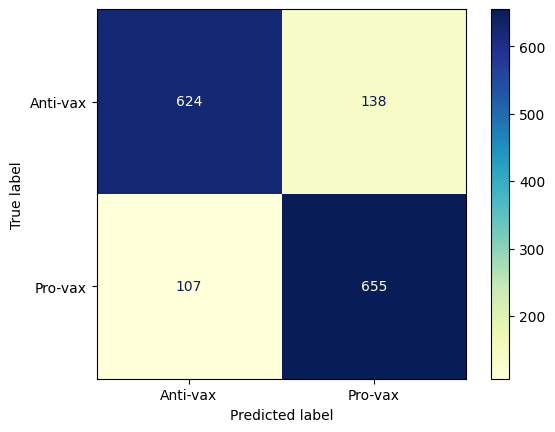

Most important anti-vaccination words: ['people' 'will' 'be' 'never' 'with' 'me' 'don' 'so' 'all' 'if' 'we'
 'from' 'do' 'dont' 'your' 'taking' 'on' 'getting' 'what' 'was']
Most important pro-vaccination words: ['people' 'be' 'we' 'so' 'all' 'as' 'but' 'getting' 'just' 'can' 'will'
 'with' 'if' 'had' 'your' 'first' 'from' '19' 'who' 'shot']


In [21]:
vip_anti_words = ['the', 'to', 'it', 'and', 'is', 'you', 'of',                   
'that', 'are', 'this', 'for', 'they', 'in',                  
'not', 'no', 'vaccine', 'my', 'take', 'vaccines', 'covid']
# keep: 'not', 'no', 'vaccine', 'my', 'take', 'vaccines','covid'

vip_pro_words = ['the', 'to', 'and', 'of', 'it', 'is', 'you', 'for',                  
'in', 'are', 'that', 'have', 'got', 'this',                  
'vaccine', 'get', 'my', 'vaccinated', 'vaccines', 'covid']
# keep: 'vaccine'‚ 'get', 'my'‚ 'vaccinated'‚ 'vaccines', 'covid'

merged_stop_list = vip_anti_words + vip_pro_words
print("Now removing: ")
print(merged_stop_list)

# TFID Vectorize the train and test data
tfid_vect = TfidfVectorizer(strip_accents='ascii', stop_words= merged_stop_list, norm='l2')

vectorized_train_consensus = tfid_vect.fit_transform(traindf_only_consensus['comment'])
vectorized_test = tfid_vect.transform(testdf['comment']) # Use same vectorizer for test data


test_algo(MultinomialNB(alpha=0.6), vectorized_test, testdf['comment'], 
testdf['stance'])


Now removing: 
['the', 'to', 'it', 'and', 'is', 'you', 'of', 'that', 'are', 'this', 'for', 'they', 'in', 'the', 'to', 'and', 'of', 'it', 'is', 'you', 'for', 'in', 'are', 'that', 'have', 'got', 'this']
              precision    recall  f1-score   support

    Anti-vax       0.86      0.82      0.84       762
     Pro-vax       0.83      0.86      0.85       762

    accuracy                           0.84      1524
   macro avg       0.84      0.84      0.84      1524
weighted avg       0.84      0.84      0.84      1524

Total accuracy of model: 0.84
Total precision of model: 0.83
Total recall of model: 0.86
True negative rate: 0.82
Negative predicted value: 0.86


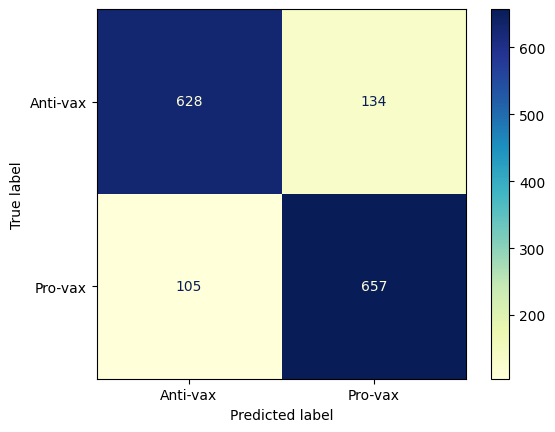

Most important anti-vaccination words: ['vaccine' 'not' 'no' 'my' 'covid' 'take' 'vaccines' 'people' 'be' 'will'
 'get' 'with' 'never' 'me' 'so' 'all' 'don' 'if' 'we' 'from']
Most important pro-vaccination words: ['vaccine' 'get' 'my' 'vaccinated' 'covid' 'vaccines' 'people' 'be' 'we'
 'so' 'not' 'all' 'as' 'but' 'getting' 'just' 'can' 'will' 'with' 'had']


In [22]:
vip_anti_words = ['the', 'to', 'it', 'and', 'is', 'you', 'of',                   
'that', 'are', 'this', 'for', 'they', 'in']
# keep: 'not', 'no', 'vaccine', 'my', 'take', 'vaccines','covid'

vip_pro_words = ['the', 'to', 'and', 'of', 'it', 'is', 'you', 'for',                  
'in', 'are', 'that', 'have', 'got', 'this']
# keep: 'vaccine'‚ 'get', 'my'‚ 'vaccinated'‚ 'vaccines', 'covid'

merged_stop_list = vip_anti_words + vip_pro_words
print("Now removing: ")
print(merged_stop_list)

# TFID Vectorize the train and test data
tfid_vect = TfidfVectorizer(strip_accents='ascii', stop_words= merged_stop_list, norm='l2')

vectorized_train_consensus = tfid_vect.fit_transform(traindf_only_consensus['comment'])
vectorized_test = tfid_vect.transform(testdf['comment']) # Use same vectorizer for test data


test_algo(MultinomialNB(alpha=0.6), vectorized_test, testdf['comment'], 
testdf['stance'])


In [17]:
# Run best machine learning model on test data
def test_algo(classifier, X_test_vectorized, X_test_not_vectorized, y_test):
    # Train and predict
    classifier.fit(vectorized_train_consensus, traindf_only_consensus['stance'])
    y_pred = classifier.predict(X_test_vectorized)
    """
    # Print 5 cases that were missclassified
    print("5 misslassified comments:")
    i=0
    X_np = X_test_not_vectorized.to_numpy()
    y_np = y_test.to_numpy()
    for (p,t,comment) in zip(y_pred, y_np, X_np):
        if i == 5:
            break
        elif (np.random.rand() < 0.5): # To not get same comments every time the function is executed
            continue
        elif p != t:
            print("True label: {}  |  {}".format(t,comment))
            i += 1
    print("-------------------------------------------------")
    """
    # Print a classification report
    print(classification_report(y_test, y_pred, target_names = ["Anti-vax", "Pro-vax"]))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Accuracy
    acc = (tn+tp)/(tn+tp+fp+fn)
    print("Total accuracy of model: {:.2f}".format(acc))

    # Precision
    prec = tp/(tp+fp)
    print("Total precision of model: {:.2f}".format(prec))

    # Recall
    recall = tp/(tp+fn)
    print("Total recall of model: {:.2f}".format(recall))

    # True negative rate
    tnr = tn/(tn+fp)
    print("True negative rate: {:.2f}".format(tnr))

    # Negative predicted value
    npv = tn/(tn+fn)
    print("Negative predicted value: {:.2f}".format(npv))

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(classifier, X_test_vectorized, y_test, display_labels = ["Anti-vax", "Pro-vax"], cmap="YlGnBu")
    plt.savefig("eval_confusion_matrix.png")
    plt.show()
    """
    # ROC-curve
    plot_roc_curve(classifier, X_test_vectorized, y_test)
    plt.savefig("eval_roc_curve.png")
    plt.show()
    """
    # Try to look at what features the classifer considers important
    neg_class_prob_sorted = classifier.feature_log_prob_[0,:].argsort()[::-1]
    pos_class_prob_sorted = classifier.feature_log_prob_[1,:].argsort()[::-1]
    
    print("Most important anti-vaccination words: {}".format(np.take(tfid_vect.get_feature_names_out(), neg_class_prob_sorted[:20])))
    print("Most important pro-vaccination words: {}".format(np.take(tfid_vect.get_feature_names_out(), pos_class_prob_sorted[:20])))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f93a499e-42e4-47ba-a697-a51a595d57fe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>